In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font='SimHei')
plt.rcParams['axes.grid'] = False

from IPython.display import SVG

def show_image(filename, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)

    plt.imshow(plt.imread(filename))

TreeBoost原理和实现（sklearn）简介
===========================

### 前言

TreeBoost是对GBDT做了更深一步的优化，主要贡献在将整颗树的全局权重值细化到每片叶子的局部权重值。它不像xgboost在树生长时就做出指导，而是在树生长后再修正叶子值。对于工程中的GBDT模块，spark目前是传统的Gradient Boosting，而sklearn采用了TreeBoost，所以本文以sklearn为例进行说明。

本文假设读者已经了解GBDT的基本原理。

sklearn代码版本：

```sh
~/W/s/sklearn ❯❯❯ git log -n 1
commit d161bfaa1a42da75f4940464f7f1c524ef53484f
Author: John B Nelson <jnelso11@gmu.edu>
Date:   Thu May 26 18:36:37 2016 -0400

    Add missing double quote (#6831)
```

GBDT模块位于`sklearn/ensemble/gradient_boosting.py`文件，类的关系比较简单。

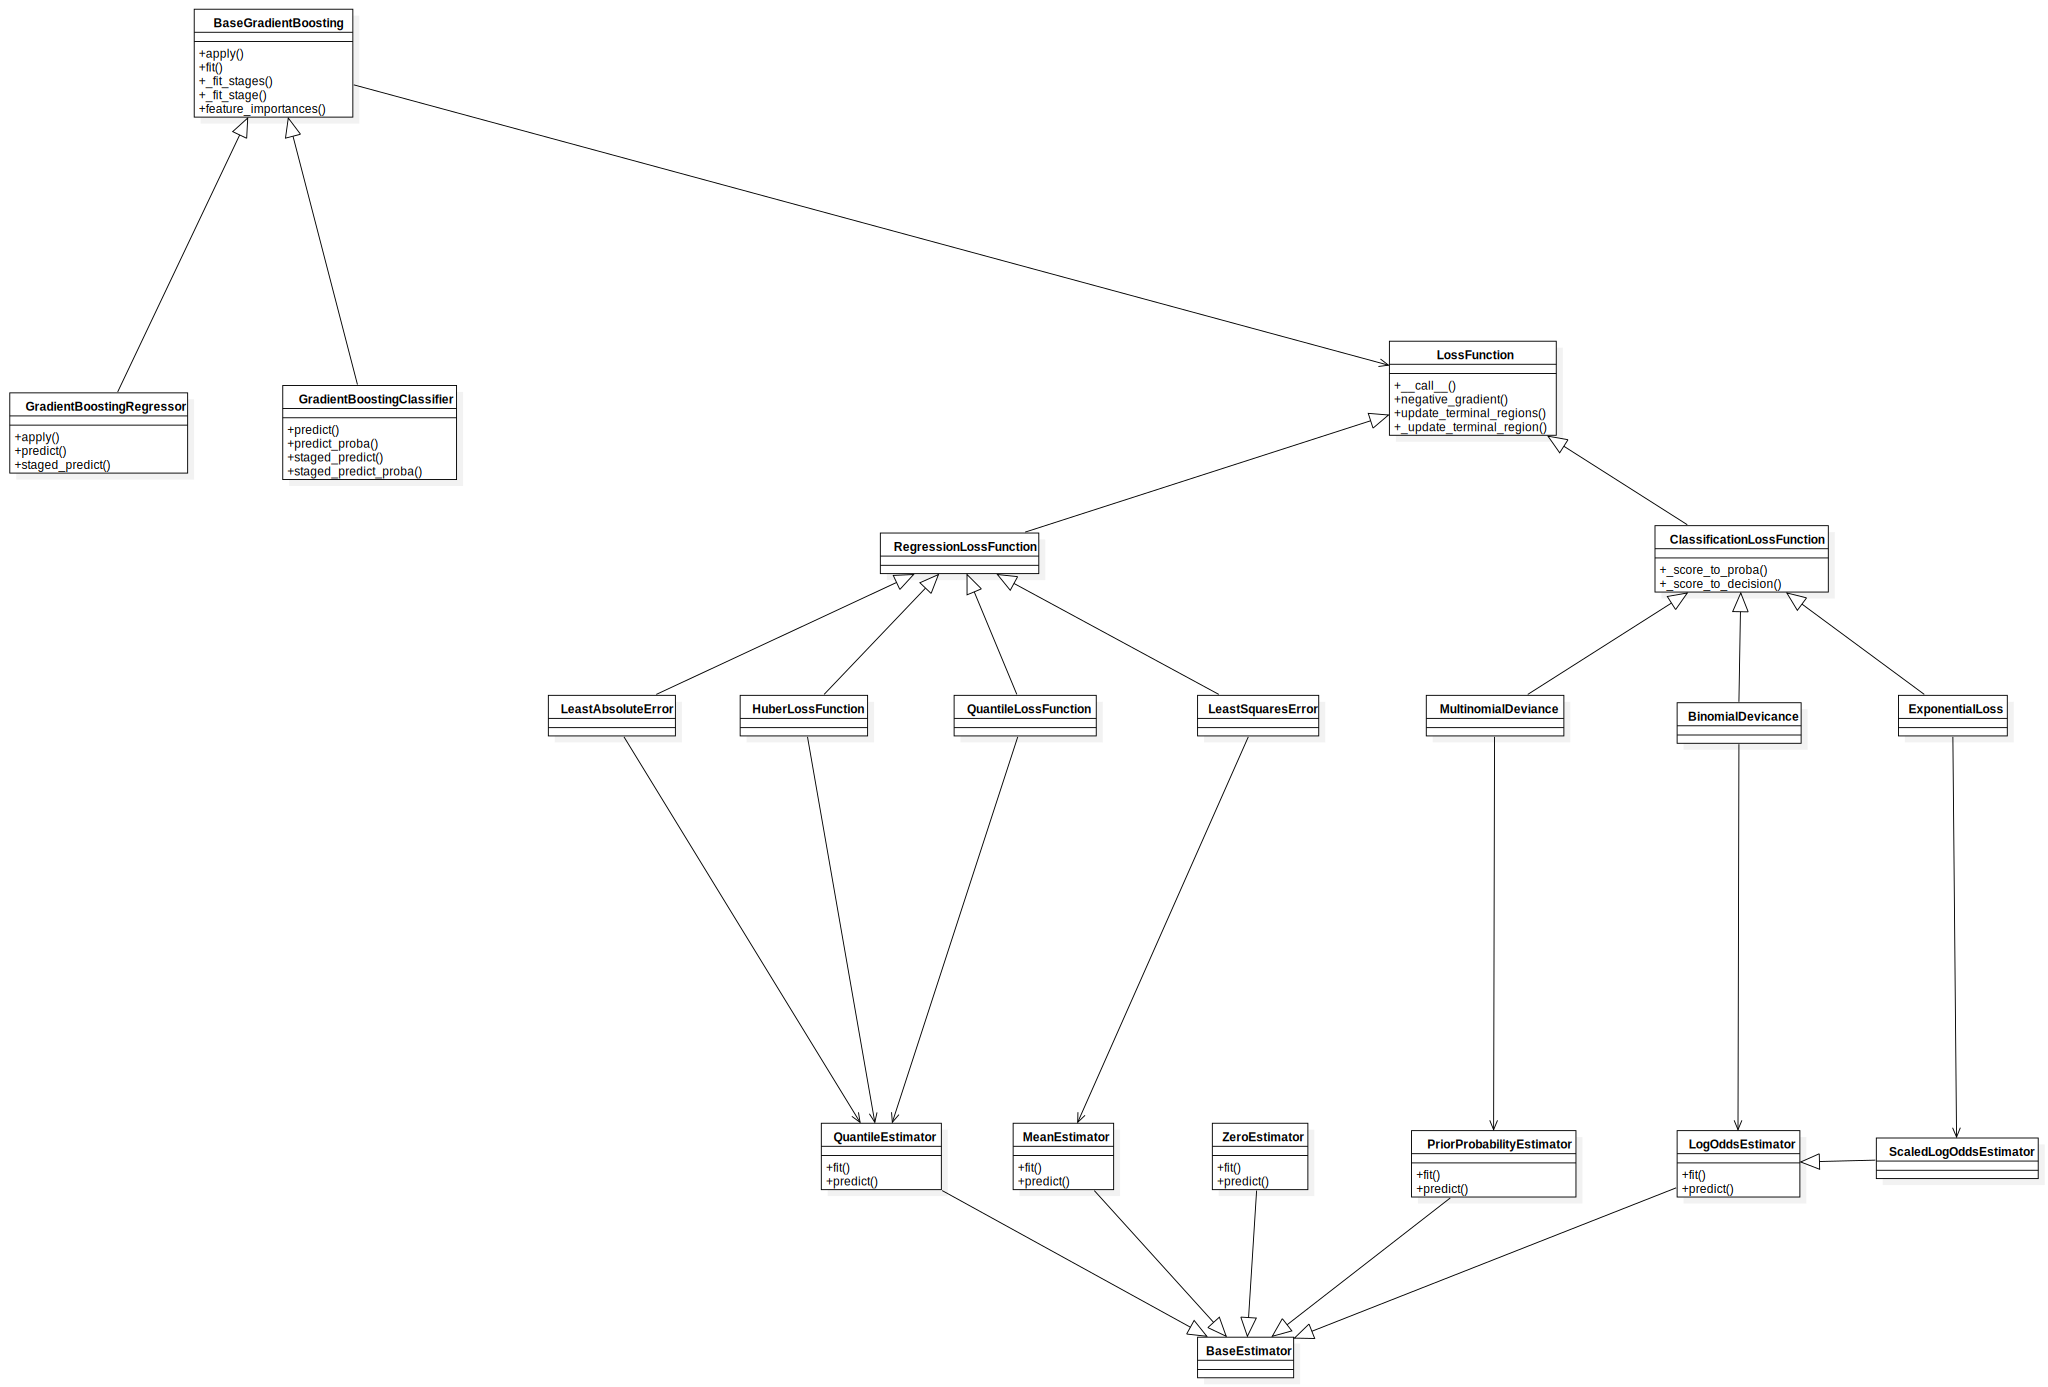

In [2]:
SVG("./res/Main.svg")

### GBDT优化

传统的Gradient Boost算法主要有四步：

1. 对损失导数求偏导；
2. 训练决策树，拟合偏导；
3. 寻优模型权值；
4. 将训练的模型，加到叠加模型中。

可以用数学公式对应表述为[1]：

+ $F_0(x) = \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N L(y_i, \rho)$

+ For $m=1$ to $M$ do:
   
   1. $\tilde{y} = - \left [ \frac{\partial L (y_i, F(x_i))}{\partial F(x_i)} \right ]_{F(x) = F_{m-1}(x)}, \quad i = 1, 2, \dotsc, N$
   
   2. $\mathbf{a}_m = \operatorname{arg \, min}_{\mathbf{a}, \beta} \displaystyle \sum_{i=1}^N \left [ \tilde{y}_i - \beta h(x_i; \mathbf{a}) \right ]^2$
   3. $\rho_m = \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N L \left ( y_i, F_{m-1}(x_i) + \rho h(x_i; \mathbf{a}_m) \right)$
   4. $F_m(x) = F_{m-1}(x) + l_r \rho_m h(x; \mathbf{a}_m)$
   
其中，$L$是损失函数， $l_r$是学习率，$\rho$是模型的权值，$h(x_i; \mathbf{a})$是决策树模型，$\mathbf{a}$是树的参数，$F$是最终累加模型。
   
利用一些数学方法和损失函数的特性，可以将第3步的权值寻优进行简化。在sklear中单步训练代码对应如下：

```Python
 748     def _fit_stage(self, i, X, y, y_pred, sample_weight, sample_mask,
 749                    random_state, X_idx_sorted, X_csc=None, X_csr=None):
 750         """Fit another stage of ``n_classes_`` trees to the boosting model. """
 751 #+--  8 lines: assert sample_mask.dtype == np.bool----------
 759
 760             residual = loss.negative_gradient(y, y_pred, k=k,
 761                                               sample_weight=sample_weight)
 762
 763             # induce regression tree on residuals
 764             tree = DecisionTreeRegressor(
 765                 criterion='friedman_mse',
 766                 splitter='best',
 767 #+---  7 lines: max_depth=self.max_depth,------------------
 774                 presort=self.presort)
 775
 776 #+---  8 lines: if self.subsample < 1.0:------------------
 784                 tree.fit(X, residual, sample_weight=sample_weight,
 785                          check_input=False, X_idx_sorted=X_idx_sorted)
 786
 787             # update tree leaves
 788 #+--  5 lines: if X_csr is not None:---------------------
 793                 loss.update_terminal_regions(tree.tree_, X, y, residual, y_pred,
 794                                              sample_weight, sample_mask,
 795                                              self.learning_rate, k=k)
 796
 797             # add tree to ensemble
 798             self.estimators_[i, k] = tree
 799
 800         return y_pred
```

其中，

+ 760L是求解偏导。
+ 784L是生成决策树。注意，对于MSE，$\beta=1$。765L树的评价函数是friedman_mse，它是MSE的变种。我猜测$\beta$是一致的，后续有时间再深究。
+ 793L是TreeBoost做的改进，将第3步寻优全局解$\rho$转化到树内部，后面主要内容就在这。
+ 798L是加回到累加模型。


接下来，我们先就平方差和绝对值两种损失函数，对传统Gradient Boost方法进行第3步的优化，为后续TreeBoost铺路。
   
[1]: Friedman - Greedy function approximation: A gradient boosting machine

#### Least squares regression

这种损失函数定义是 $L(y, F) = \frac{1}{2} (y - F)^2$，则其导数为$\frac{\partial L}{\partial F} = -(y - F)$。将偏导代入到第1步有：

\begin{align}
    \tilde{y} &= - \left [ \frac{\partial L (y_i, F(x_i))}{\partial F(x_i)} \right ]_{F(x) = F_{m-1}(x)} \\
    &= y_i - F_{m-1}(x_i), \quad i = 1, 2, \dotsc, N \\
\end{align}

将$L$和$\tilde{y}$代入到第3步中，整理可得：

\begin{align}
    \rho_m &= \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N L \left ( y_i, F_{m-1}(x_i) + \rho h(x_i; \mathbf{a}_m) \right) \\
    &= \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N \frac{1}{2} \left ( y_i - F_{m-1}(x_i) - \rho h(x_i; \mathbf{a}_m) \right)^2 \\
    &= \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N \frac{1}{2} \left ( \tilde{y}_i - \rho h(x_i; \mathbf{a}_m) \right)^2 \\
    &= \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N \left ( \tilde{y}_i - \rho h(x_i; \mathbf{a}_m) \right)^2 \\
    &= \operatorname{arg \, min}_\beta \displaystyle \sum_{i=1}^N \left ( \tilde{y}_i - \beta h(x_i; \mathbf{a}_m) \right)^2 \quad \text{符号替换}\\
    &= \beta_m
\end{align}

也就是说，对于平方差这种损失函数，它的最优权值就是第2步中指导决策树生成时的$\beta$值。

这个算法称为LS_Boost，具体过程为：

+ $F_0(x) = \bar{y}$

+ For $m=1$ to $M$ do:
  1. $\tilde{y}_i = y_i - F_{m-1}(x_i), \quad i=1, N$
  2. $(\rho_m, \mathbf{a}_m) = \operatorname{arg \, min}_{\mathbf{a}, \rho} \displaystyle \sum_{i=1}^N \left [ \tilde{y}_i - \rho h(x_i; \mathbf{a}) \right ]^2$
  3. $F_m(x) = F_{m-1}(x) + l_r \rho_m h(x; \mathbf{a}_m)$
  
sklearn中代码如下：
  
```Python
 274 class LeastSquaresError(RegressionLossFunction):
 275     """Loss function for least squares (LS) estimation.
 276     Terminal regions need not to be updated for least squares. """
 277     def init_estimator(self):
 278         return MeanEstimator()
 279
 280     def __call__(self, y, pred, sample_weight=None):
 281         if sample_weight is None:
 282             return np.mean((y - pred.ravel()) ** 2.0)
 283         else:
 284             return (1.0 / sample_weight.sum() *
 285                     np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
 286
 287     def negative_gradient(self, y, pred, **kargs):
 288         return y - pred.ravel()
 289
 290     def update_terminal_regions(self, tree, X, y, residual, y_pred,
 291                                 sample_weight, sample_mask,
 292                                 learning_rate=1.0, k=0):
 293         """Least squares does not need to update terminal regions.
 294
 295         But it has to update the predictions.
 296         """
 297         # update predictions
 298         y_pred[:, k] += learning_rate * tree.predict(X).ravel()
 299
 300     def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
 301                                 residual, pred, sample_weight):
 302         pass
```

前面说过sklearn中$\beta=1$，则$l_r \times \beta = l_r$，所以`update_terminal_regions`这里直接用学习率和树预测值相乘。

#### Least-absolute-deviation (LAD) regression

损失函数定义为 $L(y, F) = | y - F |$，同样地，可以利用导数算出残差：

\begin{align}
    \tilde{y} &= - \left [ \frac{\partial L (y_i, F(x_i))}{\partial F(x_i)} \right ]_{F(x) = F_{m-1}(x)} \\
    &= \operatorname{sign}(y_i - F_{m-1}(x_i))\\
\end{align}

$L(y, F)$是分段函数，它的导数在正数区间恒为1，负数区间恒为-1，而在间段点$F=0$处是不可导的，人为规定为0，所以可以用sign函数来描述：

\begin{equation}
    \operatorname{sign}(x) := {
        \begin{cases}
            -1 & {\text{if }} x<0, \\
            0  & {\text{if }} x=0, \\
            1  & {\text{if }} x>0.
        \end{cases}
    }
\end{equation}


同样的，将$L$和$\tilde{y}$代入到第3步中，整理可得：

\begin{align}
    \rho_m &= \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N L \left ( y_i, F_{m-1}(x_i) + \rho h(x_i; \mathbf{a}_m) \right) \\
    &= \operatorname{arg \, min}_\rho \sum_{i=1}^N \big | y_i - F_{m-1}(x_i) - \rho h(x_i; \mathbf{a}_m) \big | \\
    &= \operatorname{arg \, min}_\rho \sum_{i=1}^N \big | h(x_i; \mathbf{a}_m) \big | \cdot \left | \frac{y_i - F_{m-1}(x_i)}{h(x_i; \mathbf{a}_m)} - \rho \right | \\
    &= \operatorname{median}_W \left \{ \frac{y_i - F_{m-1}(x_i)}{h(x_i; \mathbf{a}_m)} \right \}_1^N, \quad w_i = \big | h(x_i; \mathbf{a}_m) \big |
\end{align}

这里$\operatorname{median}_W \{ \cdot \}$是带权$w_i$的[weighted median](https://en.wikipedia.org/wiki/Weighted_median)。

注意，weighted median的概念$\operatorname{median}_W (x)$，这里的加权，应理解为$x_i$出现了$w_i$次，而不是$x_i \cdot w_i$数值。 你可以去维基页查看定义，也可以看下面的推导细节。不太好讲，但其实很简单。

在sklearn中，LAD用的TreeBoost去实现，所以没有代码对应。

#### 推导细节

\begin{align}
\rho_m &= \operatorname{arg \, min}_\rho \sum_{i=1}^N \big | h(x_i; \mathbf{a}_m) \big | \cdot \left | \frac{y_i - F_{m-1}(x_i)}{h(x_i; \mathbf{a}_m)} - \rho \right | \\
    &= \operatorname{median}_W \left \{ \frac{y_i - F_{m-1}(x_i)}{h(x_i; \mathbf{a}_m)} \right \}_1^N, \quad w_i = \big | h(x_i; \mathbf{a}_m) \big |
\end{align}

最后一步的过程比较跳，我们在这里详细说下推导。

在这之前，我们简化下符号，以利于理解，

\begin{align}
    \rho_m &= \operatorname{arg \, min}_\rho \sum_{i=1}^N \big | h(x_i; \mathbf{a}_m) \big | \cdot \left | \frac{y_i - F_{m-1}(x_i)}{h(x_i; \mathbf{a}_m)} - \rho \right | \\
     &= \operatorname{arg \, min}_\rho \sum_{i=1}^N w_i \cdot | t_i - \rho | \\
\end{align}

##### 无加权

首先，我们考虑无加权的情况，即$w_i = 1$。此时有$\rho_m = \operatorname{arg \, min}_\rho \sum_{i=1}^N | t_i - \rho |$。

有两种方法来解释为什么$\rho_m = \operatorname{median}(t_i)$:

第一种是几何方法，$| t_i - \rho |$表示两点距离。我们要找的$\rho_m$，本质上就是离所有点$t_i$总距离最短的点。所以通过作图的方法，直观理解。

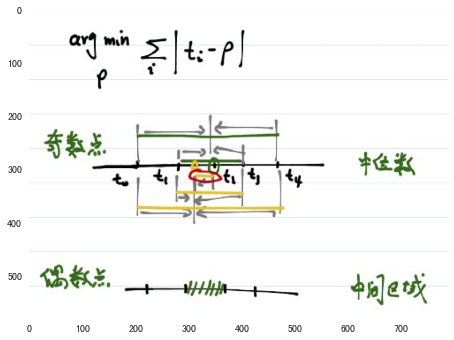

In [3]:
show_image("./res/rho_m.png")

如上图，绿色直线是中位点到各点距离，黄色直线是另一个点的距离，随着这个点外移，总距离越来越长。总结，对于奇数个点，$\rho_m$是中位点；对于偶数点，$\rho_m$在两个中间点闭区间上。

第二种方法是代数方法。

首先我们直观地了感受下结果，对于$\rho_m = \operatorname{arg \, min}_\rho \sum_{i=1}^N | t_i - \rho | = \operatorname{arg \, min} f(\rho)$，导数是$f'(\rho) = \sum_{i=1}^N \operatorname{sign}(t_i - \rho)$。在极值点$f'(\rho) = 0$，而$\operatorname{sign}(x)$只有$1, -1, 0$三种值，所以要和为0，则必然要求$1$和$-1$的数量相同。而中位点正好满足此条件[2]。

然后，在Mathematics上看到一个较为严密的论证[2]。它先算最左端结果，再向右取区间推进，证明整个过程中距离是先单减再单增的过程，从而证明中位点是最小点，具体如下：

令集合$T$含$N$个元素$t_1 < t_2 < \dots < t_N$。

1. 对于最左端$\rho < t_1$，有$f(\rho) = \sum_{i=1}^N | t_i - \rho | = \sum_{i=1}^N (t_i - \rho)$。很明显，对于每个子项，有$t_i - \rho > 0$，且$\rho \to t_1$时，$(t_i - \rho)$单减。也就是说，随着$\rho$从左向右靠近$t_1$点，所有子项都在减小，则总和$f(\rho)$单减。 

2. 选定任一区间，$t_k \leq \rho \leq \rho + d \leq t_{k+1}$，有：

\begin{align}
    f(\rho + d) &= \displaystyle \sum_{i=1}^N | t_i - (\rho + d) | \\
                &= \sum_{i=1}^k (\rho + d - t_i) + \sum_{i=k+1}^N (t_i - (\rho + d)) \\
                &= \sum_{i=1}^k (\rho - t_i) + \sum_{i=1}^k d + \sum_{i=k+1}^N (t_i - \rho) + \sum_{i=k+1}^N -d \\
                &= \sum_{i=1}^N | t_i = \rho | + k d + (N - (k+1) + 1) \times -d \\
                &= f(\rho) + d \times ( k - N + (k + 1 ) -1 ) \\
                &= f(\rho) + d \times (2k - N)
\end{align}

则有：

\begin{equation}
    f(\rho + d) = \begin{cases}
        < f(\rho), \quad \text{when } k < \frac{N}{2} \\
        = f(\rho), \quad \text{when } k = \frac{N}{2} \\
        > f(\rho), \quad \text{when } k > \frac{N}{2} \\
    \end{cases}
\end{equation}

也就是说，在$k < \frac{N}{2}$区间，$f(\rho)$单减；在$k > \frac{N}{2}$区间，$f(\rho)$单增。所以，在中位点$\frac{N}{2}$处，$f(\rho)$是最小值。于是得$\rho_m = \operatorname{median}(t_i)$。

[2]: http://math.stackexchange.com/questions/113270/the-median-minimizes-the-sum-of-absolute-deviations

##### 有加权

\begin{equation}
    \rho_m = \operatorname{arg \, min}_\rho \sum_{i=1}^N w_i \cdot | t_i - \rho |
\end{equation}

对于加权，有点无从下手的感觉。我们可以换个角度，会提供点有意思的想法。

假设$w_i$是正整数，则$w_i \ cdot | t_i - \rho | = \sum_{k=1}^{w_i} | t_i - \rho |$，也就是说，相当于将集合$T$中的$t_i$点扩增到$w_i$个。那么，可以展开为：

\begin{align}
    \rho_m &= \operatorname{arg \, min}_\rho \sum_{i=1}^N w_i \cdot | t_i - \rho | \\
           &= \operatorname{arg \, min}_\rho \sum_{i=1}^N \sum_{k=1}^{w_i} | t_i - \rho | \\
           &= \operatorname{arg \, min}_\rho \sum_{t_i \in T'} | t_i - \rho | \quad \text{$T'$ 是$t_i$扩增$w_i$倍的集合} 
\end{align}

于是，有加权问题就变更到无加权的问题。这时，我们可以将解法表示如下： 

1. 将$t_i$按升序排列。
2. 将$w_i$按对应顺序排，计算累积和$c_k = \sum_{i=1}^k w_i$。
3. 找到对应中位点$c_m = \frac{1}{2} c_N$对应的$t_m$，这个$t_m$就是$\operatorname{median}_W \{t_i\}$。

对应的sklearn代码如下：

```Python
 51 def _weighted_percentile(array, sample_weight, percentile=50):
 52     """Compute the weighted ``percentile`` of ``array`` with ``sample_weight``. """
 53     sorted_idx = np.argsort(array)
 54
 55     # Find index of median prediction for each sample
 56     weight_cdf = sample_weight[sorted_idx].cumsum()
 57     percentile_idx = np.searchsorted(
 58         weight_cdf, (percentile / 100.) * weight_cdf[-1])
 59     return array[sorted_idx[percentile_idx]]
```

当然，如果$w_i$是分数，应该怎么想，我暂时也没有思路。可以参考下维基定义[Weighted median](https://en.wikipedia.org/wiki/Weighted_median)，后续有时间，细究下。

### 从GBDT到TreeBoost

#### 回归决策树

我们先回顾前面的Gradient Boost方法，其训练公式如下：

+ For $m=1$ to $M$ do:
   
   1. $\tilde{y} = - \left [ \frac{\partial L (y_i, F(x_i))}{\partial F(x_i)} \right ]_{F(x) = F_{m-1}(x)}, \quad i = 1, 2, \dotsc, N$
   
   2. $\mathbf{a}_m = \operatorname{arg \, min}_{\mathbf{a}, \beta} \displaystyle \sum_{i=1}^N \left [ \tilde{y}_i - \beta h(x_i; \mathbf{a}) \right ]^2$
   3. $\rho_m = \operatorname{arg \, min}_\rho \displaystyle \sum_{i=1}^N L \left ( y_i, F_{m-1}(x_i) + \rho h(x_i; \mathbf{a}_m) \right)$
   4. $F_m(x) = F_{m-1}(x) + \rho_m h(x; \mathbf{a}_m)$     
      注意，为了描述方便，我移除了学习率这个乘数。

TreeBoost将外部的寻优参数内化到决策树内部，从而既让模型更精细，又加快了运行速度。而要让外部参数进入到决策树$h(x_i; \mathbf{a}_m)$，首要的问题是得打开这个函数，即使用解析式来描述。换句话说，我们需要对决策树建立数学模型。

对于$J$个叶子的回归决策树，可以表述为累加式：

\begin{equation}
    h(x; \{b_j, R_j\}_1^J) = \displaystyle \sum_{j=1}^J b_j \, \mathbf{1}(x \in R_j) 
\end{equation}

其中，$R_j$是各叶子，对应叶子的值是此区域的样本均值$b_j = \operatorname{ave}_{x_i \in R_j} y_i$。因为各个叶子是没有交集的，所以这个公式的含义等价于：如果$x \in R_j$，那么$h(x) = b_j$。

我们将回归决策树的数学式代入Gradient Boost中第四步，可得到：

\begin{align}
    F_m(x) &= F_{m-1}(x) + \rho_m h(x; \mathbf{a}_m) \\
           &= F_{m-1}(x) + \rho_M \displaystyle \sum_{j=1}^J b_{jm} \, \mathbf{1}(x \in R_{jm}) \\
           &= F_{m-1}(x) + \sum_{j=1}^J \color{red}{\rho_M b_{jm}} \, \mathbf{1}(x \in R_{jm}) \\
           &= F_{m-1}(x) + \sum_{j=1}^J \color{red}{\gamma_{jm}} \, \mathbf{1}(x \in R_{jm})
\end{align}

请注意，最后一步定义$\gamma_{jm} = \rho_M b_{jm}$，只是个简单的代数替换。但它的实质是将权重从对整颗树的全局解移动到了对各个叶子的局部解。也就是说，这个权重值更加细化了，以前是对整颗树寻优，现在是针对各个叶子，各自寻优。此时，将定义代入Gradient Boost第三步，就得到局部权重的最优解：

\begin{equation}
    \{\gamma_{jm}\}_1^J = \displaystyle \operatorname{arg \, min}_{\{\gamma_j\}_1^J} \sum_{i=1}^N L \left ( y_i, F_{m-1}(x_i) + \sum_{j=1}^J \gamma_j \mathbf{1}(x \in R_{jm}) \right )
\end{equation}

又因为各叶子$R_{jm}$是互无交集，相互独立的，上式的最优解就是各叶子各自的最优解汇总，故可简写为：

\begin{equation}
    \gamma_{jm} = \displaystyle \operatorname{arg \, min}_{\gamma} \sum_{x_i \in R_{jm}} L(y_i, F_{m-1}(x_i) + \gamma)
\end{equation}

#### LAD_TreeBoost

前面已经讨论过，对于损失函数$L(y,F) = |y - F|$，它的最优解是中位值。

故，对于LAD回归，可得：

\begin{equation}
    \gamma_{jm} = \displaystyle \operatorname{median}_{x_i \in R_{jm}} \{ y_i - F_{m-1}(x_i) \}
\end{equation}

综上，可得到LAD_TreeBoost算法如下：

+ $F_0(x) = \operatorname{median}\{y_i\}_1^N$
+ For $m=1$ to $M$ do:
   1. $\tilde{y}_i = \operatorname{sign}(y_i - F_{m-1}(x_i)), \, i=1, N$
   2. $\{R_{jm}\}_1^J = \text{$J$ terminal node tree} \big (\{\tilde{y}_i, x_i\}_1^N \big )$
   3. $\gamma_{jm} = \displaystyle \operatorname{median}_{x_i \in R_{jm}} \{ y_i - F_{m-1}(x_i)\}, \, j=1, J$
   4. $F_m(x) = F_{m-1}(x) + \displaystyle \sum_{j=1}^J \gamma_{jm} \mathbf{1}(x \in R_{jm})$
   
对应的sklearn中代码为

```python
 305 class LeastAbsoluteError(RegressionLossFunction):
 306     """Loss function for least absolute deviation (LAD) regression. """
 307     def init_estimator(self):
 308         return QuantileEstimator(alpha=0.5)
 309
 310     def __call__(self, y, pred, sample_weight=None):
 311         if sample_weight is None:
 312             return np.abs(y - pred.ravel()).mean()                                      
 313         else:
 314             return (1.0 / sample_weight.sum() *
 315                     np.sum(sample_weight * np.abs(y - pred.ravel())))
 316
 317     def negative_gradient(self, y, pred, **kargs):                                    
 318         """1.0 if y - pred > 0.0 else -1.0"""
 319         pred = pred.ravel()                                                           
 320         return 2.0 * (y - pred > 0.0) - 1.0
 321                                                                                       
 322     def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
 323                                 residual, pred, sample_weight):
 324         """LAD updates terminal regions to median estimates. """
 325         terminal_region = np.where(terminal_regions == leaf)[0]
 326         sample_weight = sample_weight.take(terminal_region, axis=0)
 327         diff = y.take(terminal_region, axis=0) - pred.take(terminal_region, axis=0)
 328         tree.value[leaf, 0, 0] = _weighted_percentile(diff, sample_weight, percentile=50)
```

其中320L就是第一步的求导，328L就是第三步将树的叶子改为中位值（percentile=50）。

因为$\tilde{y}_i$只有两种值$\tilde{y} \in \{-1, 1\}$，又叶子值是取中位数，所以这个损失的鲁棒性非常强。但求解中位数不如平均数有快速方法，所以性能会受影响。

#### M-Regression

LS_Boost运行快，LDA_TreeBoost鲁棒性好，能不能将两者结合起来呢？M-Regression的初衷正是来源于此，它用阈值$\delta$，比如说三倍方差，将$|y-F|$误差分隔成两部份：在阈值内的认定是正常误差，用LS_Boost来约束；在阈值外认定是长尾和坏值，用LDA_TreeBoost来抵抗。通过调整$\delta$值来控制平衡，从而达到各取其长的好处。

这里具体对的损失函数叫Huber，定义如下：

\begin{equation}
    L(y, F) = \begin{cases}
        \frac{1}{2} (y - F)^2 \quad & |y - F| \leq \delta \\
        \delta \cdot \left (\big |y - F \big | - \frac{\delta}{2} \right ) \quad & |y - F| > \delta 
    \end{cases}
\end{equation}

对应的具体取解推导要再参阅论文，如果后面有时间再来填坑。

在sklearn中对应的是HuberLossFunction类。

#### 二分类逻辑树
